# Testing for Peak Integration in Python using Derivative Spectra



## Preliminary on Spectral Line Shapes


### Lorentzian

Given by $L = \frac{1}{1+x^2}$

Variable $x$ is defined by $x = \frac{p-p_0}{\omega /2}$

+ $p_0$ Position of the Maximum
+ $p$ ... Position
+ $\omega$ ... Full WIdth at Half Maximum

### Gaussian 

$f(x) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x- \mu)^2}{2\sigma^2}}$

With $\mu$ expectation value and $\sigma^2$ variance.


Some useful symmetries and derivatives:

+ Unimodal: first derivative is positive for $x < \mu$ and negative for $ x > \mu$
+ First Derivative $f'(x) = - \frac{x-\mu}{\sigma^2}f(x)$
+ Second Derivative $f''(x) = \frac{(x-\mu)^2 - \sigma^2}{\sigma^4}f(x)$


### Voigt

Convolution of Gaussian and Lorentzian Function given by:

$V(x,\sigma,\gamma)= \int_{-\infty}^{\infty}G(x';\sigma)L(x-x';\gamma)dx'$





In [18]:
# Modules Import

import numpy as np
from scipy import signal
from scipy.ndimage import shift
import matplotlib.pyplot as plt

Note for a Gaussian Peak we have the Integral:

$\int_{-\infty}^{\infty} a e^{-(x-b)²/2c^2}dx = ac*\sqrt{2\pi}$

So in this test phase we can directly influence our intensity by multiplying with an arbitrary Parameter $a$

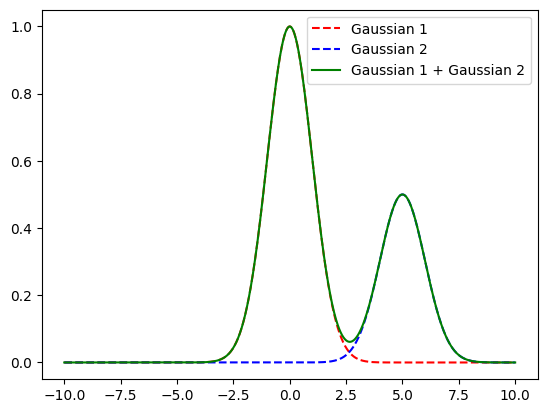

In [19]:
def gaussian(x,mean,std_dev,intensity):
    return intensity*np.exp(-(x--mean)**2/(2*std_dev**2))


x = np.linspace(-10,10,1000)

mean,std_dev,intensity = 0,1,1
mean2,std_dev2,intensity2 = 0,1,0.5

shift_horizontal = 5

y1 = gaussian(x,mean,std_dev,intensity)
y2 = gaussian(x-shift_horizontal,mean2,std_dev2,intensity2)

y_total = y1 + y2

plt.plot(x,y1,label='Gaussian 1', color = "red", linestyle = "--")
plt.plot(x,y2,label='Gaussian 2', color = "blue", linestyle = "--")
plt.plot(x,y_total ,label='Gaussian 1 + Gaussian 2', color = "green")
plt.legend()
plt.show()

In [20]:
def gaussian(x,mean,std_dev,intensity):
    return intensity*np.exp(-(x--mean)**2/(2*std_dev**2))


x = np.linspace(-10,10,1000)

mean,std_dev,intensity = 0,1,1
mean2,std_dev2,intensity2 = 0,1,0.5

shift_horizontal = 5

y1 = gaussian(x,mean,std_dev,intensity)
y2 = gaussian(x-shift_horizontal,mean2,std_dev2,intensity2)

y_total = y1 + y2

plt.plot(x,y1,label='Gaussian 1', "r--")
plt.plot(x,y2,label='Gaussian 2')
plt.plot(x,y_total ,label='Gaussian 1 + Gaussian 2')
plt.legend()
plt.show()

SyntaxError: positional argument follows keyword argument (535556992.py, line 17)